## Evaluation of Deep Q-learning

## Import Dependencies

In [1]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import gym
from collections import deque
import matplotlib.pyplot as plt

import io
import base64
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
from IPython.display import HTML
from IPython import display as ipythondisplay

if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

### Define the DQN network

In [2]:
# Define DQN network
# DQN network here is a subclass of torch.nn.module
class DQN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()

        # define the first fully connected layer that takes input features
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        # define the second fully connected layer that takes the output of the first layer
        # and maps it to another hidden representation of size 'hidden_dim'
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        # Define the output layer that maps the final hidden representation to the Q-values for each action,
        # where 'output_dim' is the number of possible actions
        self.out = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # self.fc1(x) means passing the data through the first layer called self.fc1
        # apply ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x) # return calculated output

### Define the helper function: step_env

In [3]:
def step_env(env, action):
    result = env.step(action)
    # If 4 values, legacy gym: (next_state, reward, done, info)
    if len(result) == 4:
        next_state, reward, done, info = result
    # If 5 values, new gym API: (next_state, reward, terminated, truncated, info)
    elif len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        raise ValueError("Unexpected number of values returned from env.step()")
    return next_state, reward, done, info

### Define the evaluate_dqn_agent function

In [4]:
def evaluate_dqn_agent(env, policy_net, episodes=10, max_steps=500):
    """
    Evaluate the trained DQN agent on the given environment.

    Parameters:
        env: Gym environment for evaluation.
        policy_net: The trained DQN policy network.
        episodes: Number of evaluation episodes.
        max_steps: Maximum steps per episode.

    Returns:
        List of cumulative rewards for each episode.
    """
    # Choose the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.eval()  # Set the network in evaluation mode.
    rewards = []

    for episode in range(episodes):
        # Reset the environment and handle the new Gym API format.
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # Use the policy network to select an action.
            # if episode % 100 == 0:  # Render only every 100th episode
            env.render()
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward
            # Handle possible tuple in the next state.
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            if done:
                break

        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} evaluation episodes: {avg_reward:.2f}")
    return rewards


### Initialize the DQN model

In [8]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture exactly as used during training.
input_dim = 4     # For CartPole-v1, there are 4 state values.
hidden_dim = 64   # Hidden layer size must be the same as in training.
output_dim = 2    # For CartPole-v1, there are 2 possible actions.

# Initialize the model and load the saved state dictionary.
policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
# Load the saved state dictionary into the policy network from the 'policy_net.pth' file,
policy_net.load_state_dict(torch.load("policy_net.pth", map_location=device))
policy_net.eval()  # Set the model to evaluation mode




DQN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

### Run the evaluation and record the video:

In [10]:
# Setup the evaluation environment with video recording enabled.
video_folder = "evaluation_videos"
# Define which episode to record. For example, if episodes=10, record the 10th episode (index 9).
eval_episode_to_record = 100

env = gym.make("CartPole-v1")
env = RecordVideo(env,
                  video_folder=video_folder,
                  episode_trigger=lambda ep: ep == eval_episode_to_record,
                  name_prefix="evaluation")


evaluation_rewards = evaluate_dqn_agent(env, policy_net, episodes=100)
env.close()

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

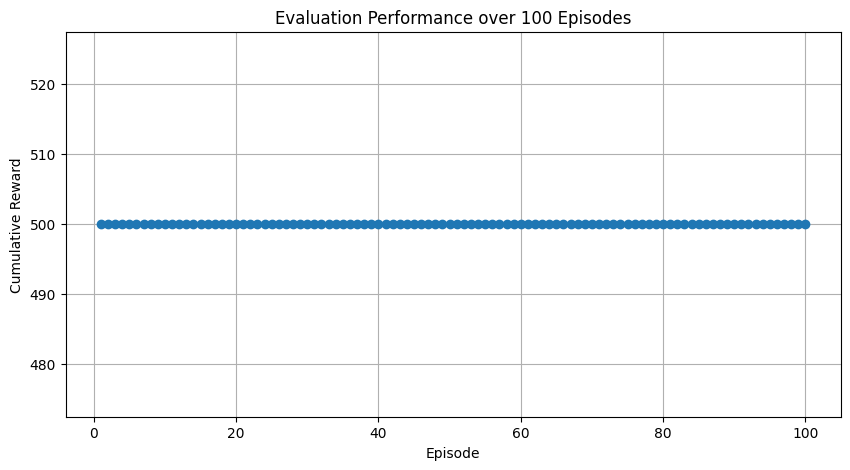

Average Reward over 100 evaluation episodes: 500.00


In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, eval_episode_to_record + 1), evaluation_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Evaluation Performance over 100 Episodes")
plt.grid(True)
plt.show()

# Also print the average reward
avg_reward = np.mean(evaluation_rewards)
print(f"Average Reward over {eval_episode_to_record} evaluation episodes: {avg_reward:.2f}")

Evaluation of video

In [12]:
from IPython.display import Video
Video("./evaluation-episode-100.mp4", embed=True)